# Chương 4. HỌC MÁY

## Nhóm Kỹ Thuật Ensemble learning

### Kỹ thuật Voting (Max voting, Averaging và Weighted averaging)

Các mô hình máy học thường bắt đầu từ một giả thuyết nhất định để giải quyết bài toán, ví dụ:
- **Hồi quy tuyến tính** giả định biến phụ thuộc \(Y\) có quan hệ tuyến tính với biến độc lập \(X\).
- **K-NN** giả định các điểm cùng lớp nằm gần nhau.
- **Decision Tree** dựa trên xác suất có điều kiện tại các node.

Tuy nhiên, trong thực tế, mối quan hệ giữa các thuộc tính có thể thay đổi theo thời gian, nên cần một phương pháp kết hợp nhiều mô hình để tăng độ chính xác.

**Ensemble Learning** ra đời từ ý tưởng đó — kết hợp nhiều mô hình yếu để tạo thành một mô hình mạnh hơn.  
Phương pháp này được áp dụng rộng rãi trong các bài toán **phân loại**, **dự báo** và **phân cụm**, và được chia thành hai nhóm:
- **Cơ bản:** Max Voting, Averaging, Weighted Averaging  
- **Nâng cao:** Bagging, Boosting, Stacking

<p align="center">
  <img src="picture/MaxVotingEnsembleLearning.drawio.png" width="600">
  <br>
  <em>Hình 1. Kỹ thuật Max Voting được áp dụng trên n mô hình phân loại, trong đó lớp dự đoán cuối cùng là lớp xuất hiện nhiều nhất trong các dự đoán từ các mô hình.</em>
</p>


In [16]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
import matplotlib.pyplot as plt

# 1. Đọc dữ liệu
col = pd.read_csv(r'data/College.csv')

# 2. Tiền xử lý
col = col[['Top10perc', 'PhD', 'Terminal', 'perc.alumni', 'Grad.Rate',
           'Top25perc', 'S.F.Ratio', 'Private', 'Expend']]
col['Private'] = col['Private'].map({'Yes': 1, 'No': 0})

# 3. X, y
X = col.drop(columns=['Private'])
y = col['Private']

# 4. Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 5. Chuẩn hóa (các mô hình như LR/SVM/KNN cần)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

# 6b. Ensemble Max Voting (Hard Voting)
log_clf = LogisticRegression(max_iter=1000, random_state=42)
svm_clf = SVC(kernel='rbf', random_state=42)          
knn_clf = KNeighborsClassifier(n_neighbors=7)
base_tree = DecisionTreeClassifier(max_depth=5, random_state=42)


In [13]:
voting_clf = VotingClassifier(
    estimators=[
        ('lr', log_clf),
        ('svm', svm_clf),
        ('knn', knn_clf),
        ('tree', base_tree),
    ],
    voting='hard',                 # Max voting
    weights=[1, 2, 1, 1]           # ưu tiên SVM (tuỳ chỉnh)
)

voting_clf.fit(X_train, y_train)
y_pred_vote = voting_clf.predict(X_test)
acc_vote = accuracy_score(y_test, y_pred_vote)
print(f"Max Voting accuracy: {acc_vote:.4f}")

Max Voting accuracy: 0.8590


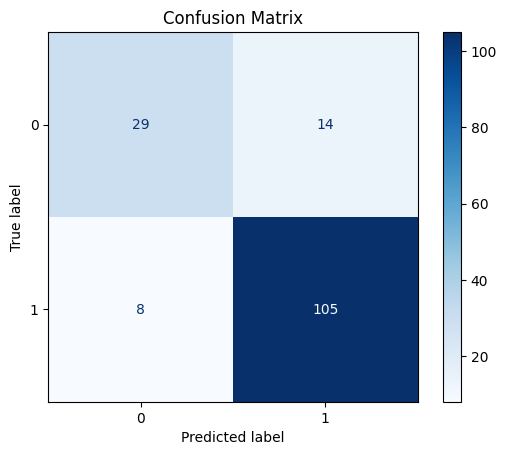

In [14]:
# 1️⃣ Tạo ma trận nhầm lẫn
cm = confusion_matrix(y_test, y_pred_vote)
# 3️⃣ Vẽ ma trận trực quan
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

### Kỹ thuật Bagging (Bootstrap Aggregating)

Phương pháp Bootstrap, do Bradley Efron giới thiệu năm 1979, là kỹ thuật lấy mẫu có hoàn lại để tạo nhiều tập dữ liệu có cùng kích thước, giúp ước lượng các đặc trưng của tổng thể như trung bình hay phương sai. Dựa trên kỹ thuật này, Bagging (Bootstrap Aggregating) huấn luyện nhiều mô hình độc lập trên các mẫu Bootstrap khác nhau rồi tổng hợp kết quả dự đoán (bằng Max voting, Average hoặc Weighted averaging). Cách làm này giúp giảm overfitting, giảm phương sai và tăng tính ổn định của mô hình.

<p align="center">
  <img src="picture/Bagging.drawio.png" width="600">
  <br>
  <em>Hình 2. Dữ liệu được chia thành n tập dữ liệu con (subdata) bằng kỹ thuật Bootstrap, sau đó n mô hình được huấn luyện song song. 
  Kết quả dự đoán sẽ được tổng hợp lại để cho kết quả cuối cùng.</em>
</p>

In [21]:
from sklearn.ensemble import BaggingClassifier

# 7. Mô hình Bagging (Bootstrap Aggregating)
bagging_clf = BaggingClassifier(
    estimator=DecisionTreeClassifier(max_depth=5, random_state=42),
    n_estimators=10,          # số mô hình con (bootstrap models)
    max_samples=0.8,           # mỗi mẫu bootstrap chứa 80% dữ liệu train
    bootstrap=True,            # cho phép lấy mẫu có hoàn lại (Bootstrap)
    random_state=42
)

# Huấn luyện
bagging_clf.fit(X_train, y_train)

# Dự đoán & đánh giá
y_pred_bag = bagging_clf.predict(X_test)
acc_bag = accuracy_score(y_test, y_pred_bag)
print(f"Bagging (Bootstrap Aggregating) Accuracy: {acc_bag:.4f}")

Bagging (Bootstrap Aggregating) Accuracy: 0.8333


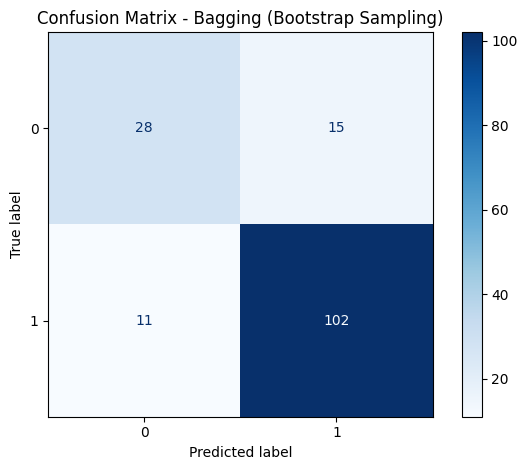

In [ ]:
# Confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_bag))
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Bagging (Bootstrap Sampling)")
plt.tight_layout()
plt.show()

### Kỹ thuật Boosting

Boosting là kỹ thuật học tăng cường trong nhóm Ensemble Learning, được giới thiệu bởi Robert Schapire (1990) và mở rộng trong AdaBoost bởi Yoav Freund và Schapire (1996). Khác với Bagging, nơi các mô hình được huấn luyện song song và độc lập, Boosting huấn luyện tuần tự, trong đó mỗi mô hình mới học từ sai lầm của mô hình trước. Các mẫu khó dự đoán được tăng trọng số để mô hình tập trung hơn vào chúng, giúp cải thiện độ chính xác qua từng vòng lặp. Cuối cùng, các mô hình yếu được kết hợp lại tạo thành một mô hình mạnh hơn.
<p align="center">
  <img src="picture/AdaBoost.drawio.png" width="600">
  <br>
  <em>Hình 3. Kỹ thuật Boosting được áp dụng trên $T$ mô hình phân loại, trong đó lớp dự đoán cuối cùng được tổng hợp lại bằng phép biến đổi tuyến tính.</em>
</p>